# Individual MUAP decomposition pipeline

Plan:

1. MUAP detection
    1. Signal enhancement
    2. MTEO computation
    3. Statistical thresholding
2. MUAP classification
    1. Windowing
    2. Interference cancelation
    3. Aligmnent
    4. Template reduction and labeling
    5. Merging
    6. Assigning MUAPS

In [1]:
import numpy as np
import wfdb
from scipy.signal import butter, filtfilt, sosfiltfilt, iirnotch, windows, find_peaks
import matplotlib.pyplot as plt

## Load signals

In [2]:
record_path = "../../emglab_dataset/raw/all/N2001A01BB01"
record = wfdb.rdrecord(record_path)
als_signal = np.array(record.p_signal).squeeze()
als_signal.shape

(262124,)

In [3]:
record_path = "../../emglab_dataset/raw/all/N2001C01BB51"
record = wfdb.rdrecord(record_path)
healthy_signal = np.array(record.p_signal).squeeze()
healthy_signal.shape

(262124,)

In [4]:
record_path = "../../emglab_dataset/raw/all/N2001M02BB01"
record = wfdb.rdrecord(record_path)
myo_signal = np.array(record.p_signal).squeeze()
myo_signal.shape

(262124,)

In [5]:
filtered_signal = myo_signal

In [6]:
sampling_rate = 23437.5

In [7]:
spike_detection_threshold = 0.0 # between -0.25 and 0.25
correlation_threshold = 0.05    # between 0.05 and 0.7

## A. MUAP detection

Detecting the initial set of MUAPs in the noisy EMG recording

### 1. Remove noise

In [8]:
def plot_filtered_signal(signal, filtered_signal):
    time = np.arange(len(signal)) / sampling_rate
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, signal, color="red")
    plt.title("Raw EMG Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.subplot(2, 1, 2)
    plt.plot(time, filtered_signal, color="blue")
    plt.title("Filtered EMG Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def filter_signal(signal, sampling_rate, notch=True, notch_freq=60, notch_q=30, lowcut=50, highcut=1000, plot=False):
    """
    Preprocess the EMG signal by:
    - Removing baseline shift (detrend)
    - Normalizing variance
    - Applying a notch filter (optional, adjustable frequency & Q)
    - Applying a bandpass filter with customizable cutoffs

    Parameters:
    signal : np.array
        The raw EMG signal.
    sampling_rate : float
        Sampling frequency.
    notch : bool, optional
        Whether to apply a notch filter (default: True).
    notch_freq : float, optional
        Frequency for the notch filter (default: 60 Hz).
    notch_q : float, optional
        Quality factor for the notch filter (default: 30).
    lowcut : float, optional
        Lower cutoff frequency for bandpass filter (default: 50 Hz).
    highcut : float, optional
        Upper cutoff frequency for bandpass filter (default: 1000 Hz).
    plot: bool, optional
        Plots the signal before and after noise removing if True (default: False).

    Returns:
    np.array
        The filtered signal.
    """
    # Remove baseline shift and normalize
    raw_signal = signal
    signal = signal - np.mean(signal)
    signal = signal / np.std(signal)

    # Apply notch filter (if enabled)
    if notch:
        nyq = 0.5 * sampling_rate
        w0 = notch_freq / nyq  # Normalize frequency
        b, a = iirnotch(w0, notch_q)
        signal = filtfilt(b, a, signal)

    # Define bandpass filter
    def butter_bandpass(lowcut, highcut, sampling_rate, order=4):
        nyq = 0.5 * sampling_rate
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], btype='band', output='sos')
        return sos

    # Apply bandpass filter
    bandpass_sos = butter_bandpass(lowcut, highcut, sampling_rate)
    signal = sosfiltfilt(bandpass_sos, signal)

    if plot:
        plot_filtered_signal(raw_signal, signal)

    return signal


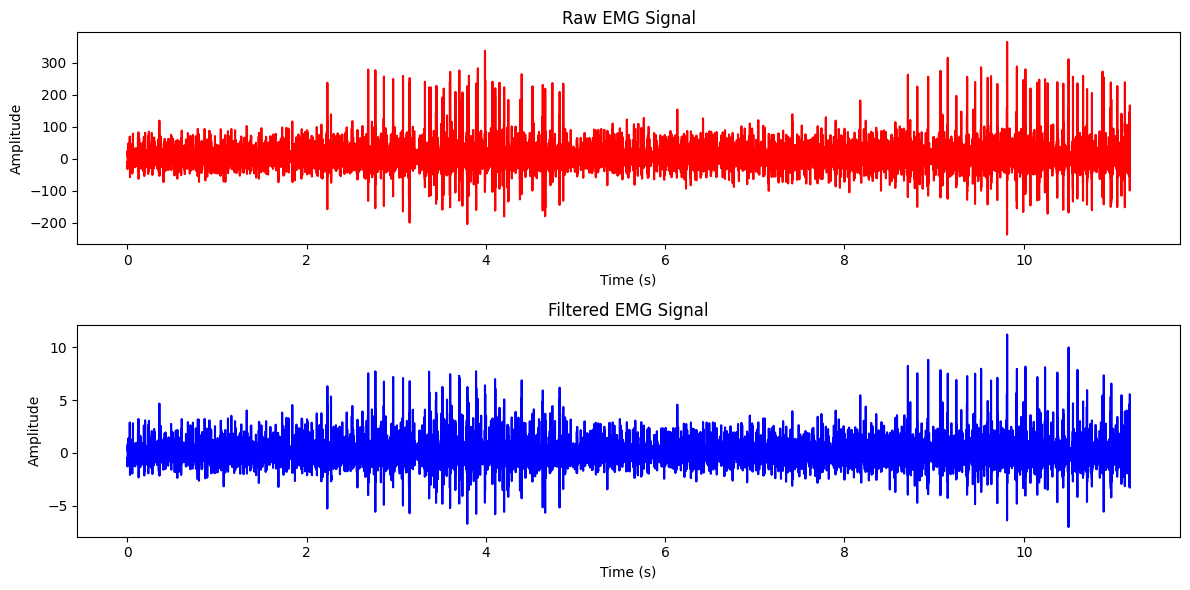

In [9]:
filtered_signal = filter_signal(filtered_signal, sampling_rate, plot=True)

### 2. MTEO computation

In [10]:
def plot_mteo_signal(signal, mteo_signal):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(signal, color="red")
    plt.title("Raw EMG Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.subplot(2, 1, 2)
    plt.plot(mteo_signal, color="blue")
    plt.title("MTEO enhanced signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def compute_mteo_signal(signal, ks=[2, 3, 5], apply_filter=True, plot=False):
    """
    Compute the Multi-Scale Teager Energy Operator (MTEO) enhanced signal.
    
    Parameters:
    signal : np.array
        The input EMG signal (should be filtered ideally).
    ks : list
        List of scales for MTEO.
    apply_filter : bool
        Whether to apply smoothing.

    Returns:
    np.array
        The MTEO-enhanced signal.
    """
    signal = signal.flatten()
    teo_signals = []

    for k in ks:
        # Compute TEO at scale k
        teo = np.zeros_like(signal)
        teo[k:-k] = signal[k:-k]**2 - signal[:-2*k] * signal[2*k:]
        
        if apply_filter:
            win = windows.hamming(4 * k + 1, sym=True)
            teo = filtfilt(win / win.sum(), [1], teo) / np.var(teo)

        teo_signals.append(teo)

    mteo_signal = np.sum(teo_signals, axis=0) if len(teo_signals) > 1 else teo_signals[0]
    if plot:
        plot_mteo_signal(signal,  mteo_signal)

    return mteo_signal

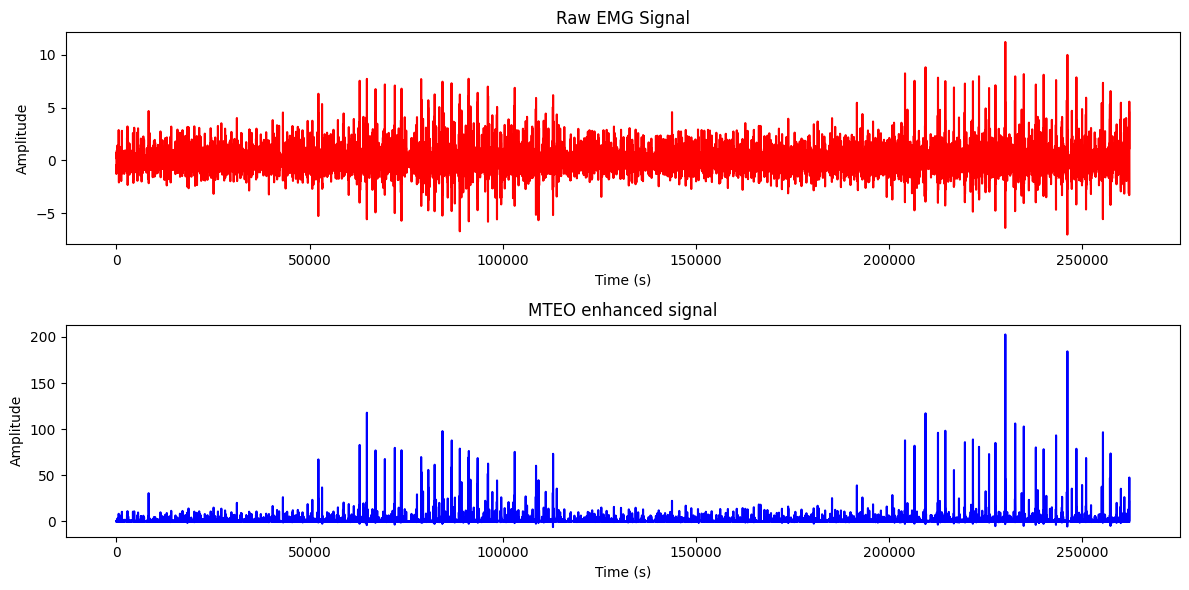

In [11]:
mteo_signal = compute_mteo_signal(filtered_signal, plot=True)

### 3. Statistical thresholding

In [12]:
def detect_muaps_locations(filtered_signal, mteo_signal, spike_detection_threshold=0.0, plot=False, window=0.02):
    """
    Multi-Scale Thresholding (MTH) for detecting MUAPs locations.
    
    Parameters:
    filtered_signal : np.array
        The input filtered signal.
    mteo_signal : np.array
        The MTEO-enhanced signal.
    spike_detection_threshold : float
        Detection threshold multiplier (-0.2 to 0.2 suggested).
    window : float
        MUAP template size (in seconds).

    Returns:
    np.array
        Locations of detected muaps.
    float
        Decision threshold.
    """
    Lmax = -551.0520
    spike_detection_threshold *= Lmax

    # Compute robust standard deviation estimate
    sigma = np.median(np.abs(mteo_signal - np.mean(mteo_signal))) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(mteo_signal)))

    # Identify spikes above threshold
    spikes = np.where(np.abs(mteo_signal) > threshold)[0]
    
    if spikes.size > 0:
        muap_mean = np.mean(np.abs(mteo_signal[spikes]))
        PS = len(spikes) / len(mteo_signal)
        PN = 1 - PS
        decision_threshold = muap_mean / 2 + (sigma**2 / muap_mean) * (spike_detection_threshold + np.log(PN / PS))
        decision_threshold = max(0, decision_threshold)

        muap_locs = spikes[np.abs(mteo_signal[spikes]) > decision_threshold]
    else:
        muap_locs = []
        decision_threshold = threshold

    # Remove MUAP locs from edges to avoid uncomplete waveforms
    start = muap_locs > round(window * sampling_rate)
    end = muap_locs < (len(filtered_signal) - round(window * sampling_rate))
    muap_locs = muap_locs[start & end]

    if plot:
        plt.figure(figsize=(15, 5))
        plt.plot(mteo_signal, label="MTEO Signal", alpha=0.7)
        plt.scatter(muap_locs, mteo_signal[muap_locs], color='red')
        plt.axhline(decision_threshold, color='green', linestyle="--")
        plt.axhline(-decision_threshold, color='green', linestyle="--")
        plt.figtext(0.1, 0.90, f'Detected muaps: {len(muap_locs)}')
        plt.legend(['MTEO signal', 'Detected MUAP locations', 'Threshold'])
        plt.title("MUAP locations detection using statistical thresholding")
        plt.xlim(0, len(mteo_signal))
        plt.show()

    return muap_locs, decision_threshold

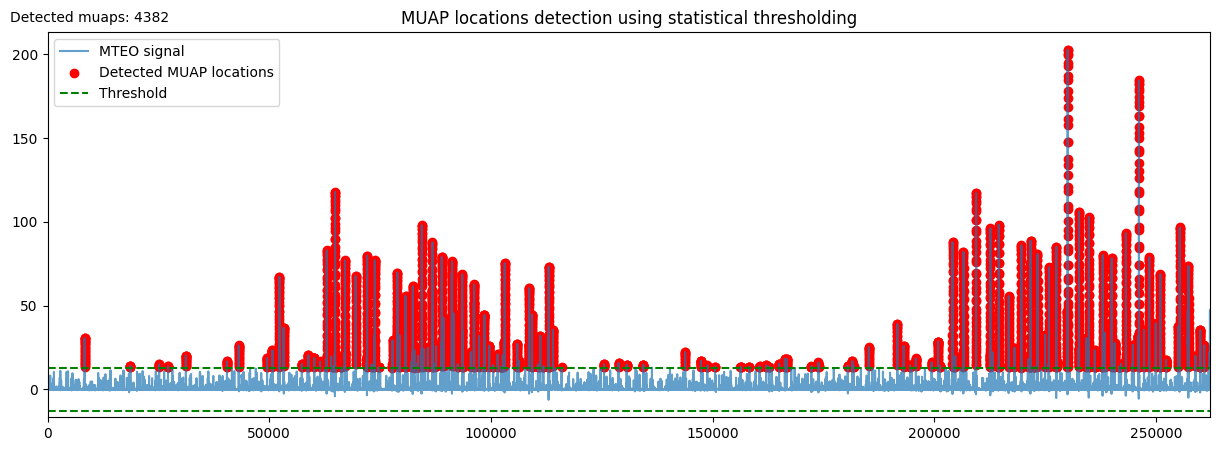

In [13]:
muap_locs, decision_threshold = detect_muaps_locations(filtered_signal, mteo_signal, spike_detection_threshold, plot=True)

## B. MUAP classification

### 1. Windowing (Extracting MUAP segments from the filtered EMG and the MTEO signal)

In [14]:
def extract_muap_templates(filtered_signal, mteo_signal, muap_locs, sampling_rate, window_duration=0.02, plot=False):
    """
    Extract MUAP templates from filtered_signal and MTEO signal around detected MUAP locations.
    
    Parameters:
    -----------
    filtered_signal : np.array
        The filtered signal.
    mteo_signal : numpy.ndarray
        The MTEO-enhanced signal
    muap_locs : numpy.ndarray
        Indices of detected MUAPs in the signal
    sampling_rate : int
        Sampling rate of the signal in Hz
    window_duration : float, optional
        Duration of the window in seconds, default is 20ms
    plot : bool, optional
        Whether to plot the extracted templates
        
    Returns:
    --------
    templates : numpy.ndarray
        2D array where each row is a MUAP template of filtered signal
    mteo_templates : numpy.ndarray
        2D array where each row is a MUAP template of MTEO enhanced signal
    aligned_locs : numpy.ndarray
        Aligned locations of the MUAPs
    """
    # Calculate window size in samples
    half_window = int(window_duration * sampling_rate / 2)
    window_size = 2 * half_window
    
    # Initialize arrays
    num_muaps = len(muap_locs)
    templates = np.zeros((num_muaps, window_size))
    mteo_templates = np.zeros((num_muaps, window_size))
    aligned_locs = np.copy(muap_locs)  # Start with original locations
    
    # Ensure signals are flattened
    filtered_signal = np.asarray(filtered_signal).flatten()
    mteo_signal = np.asarray(mteo_signal).flatten()
    
    for i, loc in enumerate(muap_locs):
        # Extract window with boundary handling
        start_idx = max(0, loc - half_window)
        end_idx = min(len(filtered_signal), loc + half_window)
        
        # Get the actual window segments
        signal_segment = filtered_signal[start_idx:end_idx]
        mteo_segment = mteo_signal[start_idx:end_idx]
        
        # Handle alignment within valid boundaries
        if len(signal_segment) > 3 and start_idx > 0 and end_idx < len(filtered_signal):
            # Find peaks for alignment
            peaks, _ = find_peaks(np.abs(signal_segment))
            if len(peaks) > 0:
                # Find peak closest to center
                center_offset = loc - start_idx
                closest_peak = peaks[np.argmin(np.abs(peaks - center_offset))]
                aligned_loc = start_idx + closest_peak
                
                # Recalculate window if alignment changed the location
                if aligned_loc != loc:
                    aligned_locs[i] = aligned_loc
                    new_start = max(0, aligned_loc - half_window)
                    new_end = min(len(filtered_signal), aligned_loc + half_window)
                    signal_segment = filtered_signal[new_start:new_end]
                    mteo_segment = mteo_signal[new_start:new_end]
        
        # Place segments into templates with zero padding if needed
        if start_idx == 0:  # Left boundary
            pad_left = loc - start_idx
            templates[i, half_window-pad_left:half_window-pad_left+len(signal_segment)] = signal_segment
            mteo_templates[i, half_window-pad_left:half_window-pad_left+len(mteo_segment)] = mteo_segment
        elif end_idx == len(filtered_signal):  # Right boundary
            pad_right = end_idx - loc
            templates[i, :len(signal_segment)] = signal_segment
            mteo_templates[i, :len(mteo_segment)] = mteo_segment
        else:  # No boundary issues
            templates[i, :len(signal_segment)] = signal_segment
            mteo_templates[i, :len(mteo_segment)] = mteo_segment
    
    if plot:
        plt.figure(figsize=(12, 6))
        plt.subplot(3, 1, 1)
        plt.plot(mteo_signal)
        plt.scatter(aligned_locs, mteo_signal[aligned_locs], color='green', marker='x')
        plt.title("Aligned MUAP locations")
        plt.subplot(3, 1, 2)
        [plt.plot(template, alpha=0.7) for template in templates]
        plt.title(f"Filtered signal MUAP templates ({len(templates)} templates)")
        plt.subplot(3, 1, 3)
        [plt.plot(mteo_template, alpha=0.7) for mteo_template in mteo_templates]
        plt.title(f"MTEO signal MUAP templates ({len(mteo_templates)} templates)")
        plt.tight_layout()

    return templates, mteo_templates, aligned_locs

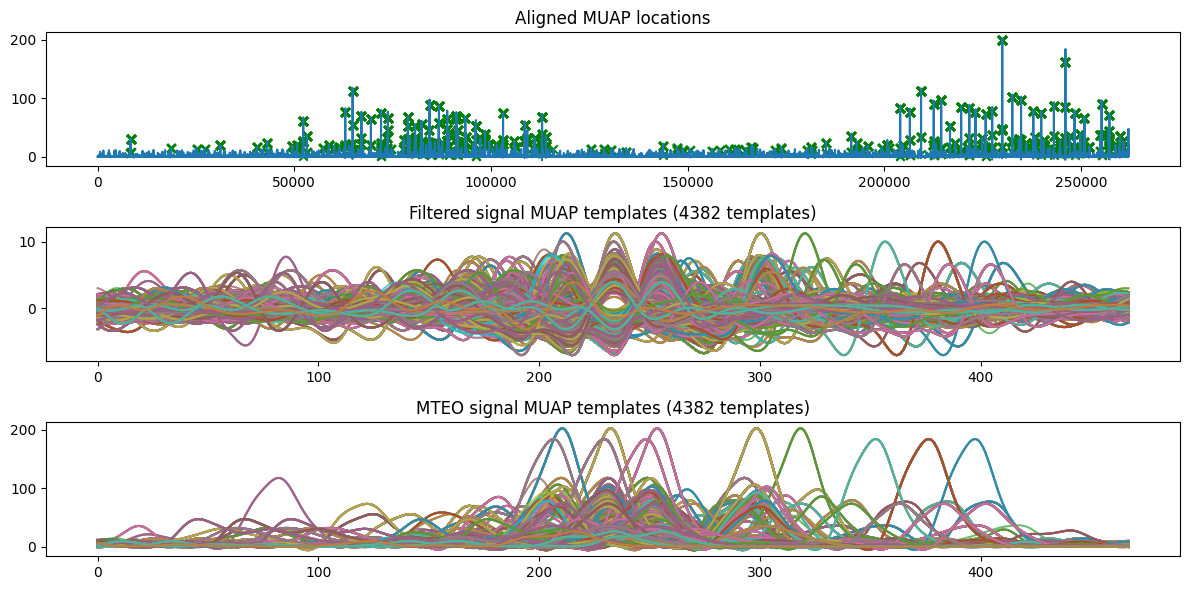

In [15]:
templates, mteo_templates, aligned_locs = extract_muap_templates(filtered_signal, mteo_signal, muap_locs, sampling_rate, plot=True)

### 2. Interference cancelation (resolving superimposed MUAPS)


In [16]:
# TODO: interference cancelation function: takes the muap_templates and muap_mteo_templates and returns muap_templates and muap_mteo_templates modified

def interference_cancelation(templates, mteo_templates, decision_threshold, plot=False, window_duration=0.02):
    """
    Removes interference by zeroing out uncorrelated sections.
    
    Parameters:
    templates : numpy.ndarray
        Window of original signal around a MUAP
    mteo_templates : numpy.ndarray
        Window of MTEO signal around a MUAP
    decision_threshold : float
        Decision threshold for MUAP detection
    
    Returns:
    templates : numpy.ndarray
        Signal window with interference removed
    mteo_templates : numpy.ndarray
        MTEO window with interference removed
    plot : bool, optional
        Whether to plot the extracted templates
    """

    for template, mteo_template in zip(templates, mteo_templates):
        # Calculate window size in samples
        half_window = int(window_duration * sampling_rate / 2)

        # Check for peaks in the first half of the window
        peaks, _ = find_peaks(mteo_template[:half_window])
        if peaks.size > 0:
            valid_peaks = peaks[mteo_template[peaks] >= decision_threshold]
            if valid_peaks.size > 0:
                max_peak = valid_peaks[-1]  # Take the last valid peak
                # Find the first minimum after the peak
                inverted = 1.01 * np.max(mteo_template[max_peak:half_window]) - mteo_template[max_peak:half_window]
                min_peaks, _ = find_peaks(inverted)
                if min_peaks.size > 0:
                    min_peak = max_peak + min_peaks[0]
                    # Zero out signal before the minimum
                    mteo_template[:min_peak] = 0
                    template[:min_peak] = 0
        
        # Check for peaks in the second half of the window
        peaks, _ = find_peaks(mteo_template[half_window:])
        if peaks.size > 0:
            valid_peaks = peaks[mteo_template[half_window + peaks] >= decision_threshold]
            if valid_peaks.size > 0:
                max_peak = valid_peaks[0]  # Take the first valid peak
                # Find the last minimum before the peak
                inverted = 1.01 * np.max(mteo_template[half_window:half_window + max_peak]) - mteo_template[half_window:half_window + max_peak]
                min_peaks, _ = find_peaks(inverted)
                if min_peaks.size > 0:
                    min_peak = min_peaks[-1]
                    # Zero out signal after the minimum
                    mteo_template[half_window + max_peak + min_peaks[-1]:] = 0
                    template[half_window + max_peak + min_peaks[-1]:] = 0
    
    if plot:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        [plt.plot(template, alpha=0.7) for template in templates]
        plt.title(f"Filtered signal MUAP templates ({len(templates)} templates)")
        plt.subplot(2, 1, 2)
        [plt.plot(mteo_template, alpha=0.7) for mteo_template in mteo_templates]
        plt.title(f"MTEO signal MUAP templates ({len(mteo_templates)} templates)")
        plt.tight_layout()
        plt.show()

    return templates, mteo_templates

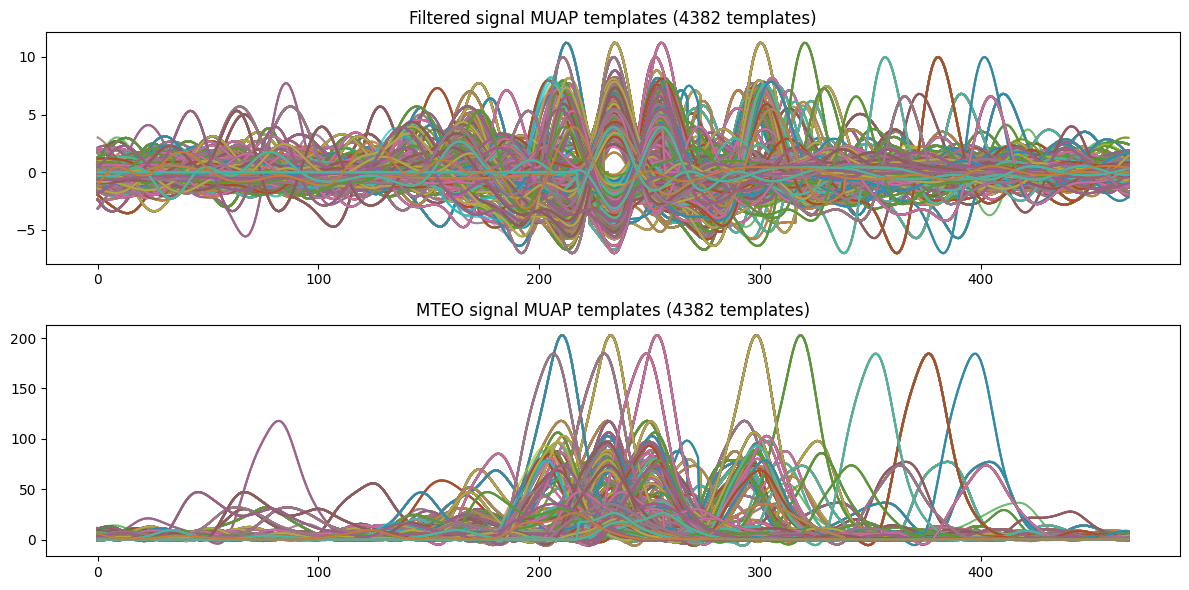

In [17]:
templates, mteo_templates = interference_cancelation(templates, mteo_templates, decision_threshold, plot=True)

### 3. Template reduction and labelling

In [18]:
def border_detector(template, mteo_template, TH, TH1):
    """
    Extracts features based on detected peak boundaries.
    
    Parameters:
    mteo_window : numpy.ndarray
        Window of MTEO signal around a MUAP
    signal_window : numpy.ndarray
        Window of original signal around a MUAP
    TH : float
        Decision threshold for MUAP detection
    TH1 : float
        Threshold for feature extraction
    
    Returns:
    features : numpy.ndarray
        Array of features extracted from the MUAP
    """
    # Find peaks in the MTEO window
    peaks, _ = find_peaks(mteo_template)
    
    # Filter peaks above threshold
    valid_maxima = peaks[mteo_template[peaks] > TH]
    
    # Limit number of maxima to 5
    if len(valid_maxima) > 5:
        valid_maxima = valid_maxima[:5]
    
    # Initialize feature vector
    features = np.full(24, np.nan)
    
    # Compute border distances
    D_border = np.zeros(len(valid_maxima))
    for i, B in enumerate(valid_maxima):
        # Find left border
        left = np.where(template[:B] <= TH1)[0]
        left_border = B - (left[-1] if left.size > 0 else np.argmin(template[:B]))
        
        # Find right border
        right = np.where(template[B:] <= TH1)[0]
        right_border = (right[0] if right.size > 0 else np.argmin(template[B:]))
        
        # Store total border distance
        D_border[i] = left_border + right_border
    
    # Determine amplitude polarity (1 for negative, 2 for positive)
    amp = np.where(mteo_template[valid_maxima] < 0, 1, 2)
    
    # Fill feature vector with extracted features
    features[:len(amp)] = amp  # Amplitude polarity
    features[5:5+len(D_border)] = D_border  # Border distances
    if len(valid_maxima) > 1:
        features[10:10+len(np.diff(valid_maxima))] = np.diff(valid_maxima)  # Peak distances
    features[14:14+len(amp)] = template[valid_maxima]  # MTEO values at peaks
    features[19:19+len(amp)] = valid_maxima  # Peak positions
    
    return features

In [19]:
features = border_detector(templates[0], mteo_templates[0], decision_threshold, correlation_threshold)

In [20]:
features

array([  2.        ,          nan,          nan,          nan,
                nan,  26.        ,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,   4.63305017,          nan,
                nan,          nan,          nan, 253.        ,
                nan,          nan,          nan,          nan])

### 5. Merging (grouping templates that are similar together)

In [21]:
# TODO: template matching approach known as pseudocorrelation

### 6. Assigning MUAPS

In [22]:
# TODO: assign each MUAP in the raw signal to a specific template generated in the previous steps